# 取り組む課題「2つの重なった手書き数字の識別」
まずは重なった手書き数字を作る。  
これはなんとか作成できた。  
(最初は配列を合計して2で割っていたが、文字が薄くなったので、np.maximum関数で大きい数字をとるようにした。)

In [1]:
#いつものやつ
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
# 乱数シードを指定
np.random.seed(seed=0)

In [2]:
#mnistの準備
if os.path.exists('mnist_784'):
    with open('mnist_784','rb') as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml('mnist_784')
    with open('mnist_784', 'wb') as f:
        pickle.dump(mnist, f)
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2)

# ラベルデータをint型にし、one-hot-vectorに変換します
t_train = np.eye(10)[t_train.astype("int")]
t_test = np.eye(10)[t_test.astype("int")]

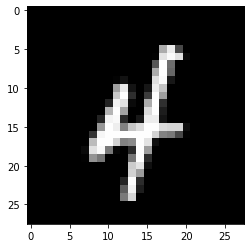

Label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] ⇒ [4]


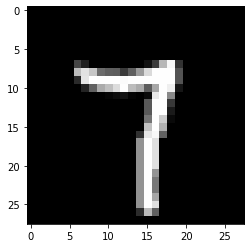

Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] ⇒ [7]


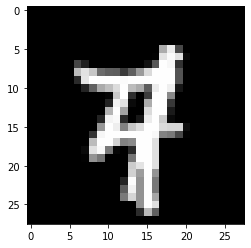

Label: [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] ⇒ [4 7]


In [3]:
rand0 = np.random.randint(0,len(x_train))
rand1 = np.random.randint(0,len(x_train))

plt.gray()
plt.imshow(x_train[rand0].reshape((28,28)))
plt.show()
print("Label",t_train[rand0],"⇒",np.sort(t_train[rand0].argsort()[-1:]))

plt.gray()
plt.imshow(x_train[rand1].reshape((28,28)))
plt.show()
print("Label:",t_train[rand1],"⇒",np.sort(t_train[rand1].argsort()[-1:]))

x_train_overlap = np.maximum(x_train[rand0],x_train[rand1])
t_train_overlap = np.maximum(t_train[rand0],t_train[rand1])
plt.gray()
plt.imshow(x_train_overlap.reshape((28,28)))
plt.show()
print("Label:",t_train_overlap,"⇒",np.sort(t_train_overlap.argsort()[-2:]))

次にネットワークを作製したが、片方の数字しか正解しないネットワークになってしまった。  
必死に考えたがよくわからなかったので、中間面談を利用して相談してみた。  
  
すると、ソフトマックス関数が1つの解答を得るときに使う関数だと教えてもらえた。  
回帰問題になるのでDay1のプログラムを改良したほうが良いともアドバイスをもらった。  
正直CNNになると思っていたので、これは大変ありがたいお答えでした(^^♪

In [4]:
def relu(v):
    x = np.maximum(0,v)
    return x

def MSE(t, y):
    mse = np.mean(np.square(t-y))
    return mse

class MLP_regressor():
    def __init__(self):
        # 重みの定義
        self.w1 = np.random.randn(784, 50) * 0.1
        self.w2 = np.random.randn(50, 50) * 0.1
        self.w3 = np.random.randn(50, 10) * 0.1
        self.w4 = np.random.randn(10, 10) * 0.1

        # バイアスの定義
        self.b1 = np.zeros(50, dtype=float)
        self.b2 = np.zeros(50, dtype=float)
        self.b3 = np.zeros(10, dtype=float)
        self.b4 = np.zeros(10, dtype=float)

    def forward(self, x):
        self.layer0 = x
        self.layer1 = relu(np.dot(self.layer0,self.w1)+self.b1)#### 問1-3 ####
        self.layer2 = relu(np.dot(self.layer1,self.w2)+self.b2)#### 問1-4 ####
        self.layer3 = relu(np.dot(self.layer2,self.w3)+self.b3)#### 問1-5 ####
        self.out = np.dot(self.layer3,self.w4)+self.b4#### 問1-6 ####
        return self.out

    def backward(self, t, y):
        # 出力層の誤差デルタは二乗誤差の微分
        delta4 = -2*(t-y)#### 問1-7 ####
        # 誤差逆伝播
        delta3 = np.dot(delta4,np.transpose(self.w4))#### 問1-8 ####
        delta2 = np.dot(delta3*(self.layer3 > 0),np.transpose(self.w3))#### 問1-9 ####
        delta1 = np.dot(delta2*(self.layer2 > 0),np.transpose(self.w2))#### 問1-10 ####

        # バイアスbのコスト関数eに対する勾配
        self.dedb4 = np.mean(delta4, axis=0)
        self.dedb3 = np.mean(delta3 * (self.layer3 > 0), axis=0)
        self.dedb2 = np.mean(delta2 * (self.layer2 > 0), axis=0)
        self.dedb1 = np.mean(delta1 * (self.layer1 > 0), axis=0)

        # 重みwのコスト関数eに対する勾配
        self.dedw4 = np.dot(self.layer3.T, delta4) / delta4.shape[0]
        self.dedw3 = np.dot(self.layer2.T, delta3 * (self.layer3 > 0)) / delta3.shape[0]
        self.dedw2 = np.dot(self.layer1.T, delta2 * (self.layer2 > 0)) / delta2.shape[0]
        self.dedw1 = np.dot(self.layer0.T, delta1 * (self.layer1 > 0)) / delta1.shape[0]

    def optimize_GradientDecent(self, lr):
        self.b1 -= lr * self.dedb1
        self.b2 -= lr * self.dedb2
        self.b3 -= lr * self.dedb3
        self.b4 -= lr * self.dedb4

        self.w1 -= lr * self.dedw1
        self.w2 -= lr * self.dedw2
        self.w3 -= lr * self.dedw3
        self.w4 -= lr * self.dedw4

まずは通常のmnist

In [6]:
# モデルの定義
model = MLP_regressor()
# 学習率
lr = 0.1
# 学習エポック数
n_epoch = 500
# 正答率
acc_list = []
acc_list_two=[]
# n_epoch繰り返す
for n in range(n_epoch):
    # 訓練
    x=x_train/255
    t=t_train
    y=model.forward(x)
    train_loss=MSE(t,y)
    model.backward(t,y)
    model.optimize_GradientDecent(lr)
    
    # テスト
    y = model.forward(x_test/255)
    acc_list.append((y.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    print("EPOCH:",n+1,"TrainLoss:",train_loss,"Accuracy:",acc_list[-1])

EPOCH: 1 TrainLoss: 0.10335845694160065 Accuracy: 0.09728571428571428
EPOCH: 2 TrainLoss: 0.09687345934950982 Accuracy: 0.1055
EPOCH: 3 TrainLoss: 0.09378391172193262 Accuracy: 0.11714285714285715
EPOCH: 4 TrainLoss: 0.09201989106912394 Accuracy: 0.12964285714285714
EPOCH: 5 TrainLoss: 0.09093290590232246 Accuracy: 0.14464285714285716
EPOCH: 6 TrainLoss: 0.09022794242913282 Accuracy: 0.155
EPOCH: 7 TrainLoss: 0.08974891297040091 Accuracy: 0.16592857142857143
EPOCH: 8 TrainLoss: 0.08940814626735039 Accuracy: 0.17714285714285713
EPOCH: 9 TrainLoss: 0.08915202581640146 Accuracy: 0.18692857142857142
EPOCH: 10 TrainLoss: 0.08894787167000695 Accuracy: 0.1955
EPOCH: 11 TrainLoss: 0.08877511543973528 Accuracy: 0.20135714285714285
EPOCH: 12 TrainLoss: 0.08862156710776446 Accuracy: 0.207
EPOCH: 13 TrainLoss: 0.0884785802186355 Accuracy: 0.21235714285714286
EPOCH: 14 TrainLoss: 0.08834141177544573 Accuracy: 0.21828571428571428
EPOCH: 15 TrainLoss: 0.08820664841981217 Accuracy: 0.22335714285714287

EPOCH: 122 TrainLoss: 0.06465635653599325 Accuracy: 0.5415
EPOCH: 123 TrainLoss: 0.06444584679860223 Accuracy: 0.5432857142857143
EPOCH: 124 TrainLoss: 0.06423689799437593 Accuracy: 0.5457142857142857
EPOCH: 125 TrainLoss: 0.06402980375210673 Accuracy: 0.5477857142857143
EPOCH: 126 TrainLoss: 0.06382458332934937 Accuracy: 0.5497142857142857
EPOCH: 127 TrainLoss: 0.0636217234672083 Accuracy: 0.5519285714285714
EPOCH: 128 TrainLoss: 0.06342096426517352 Accuracy: 0.5537857142857143
EPOCH: 129 TrainLoss: 0.06322257277454077 Accuracy: 0.5557142857142857
EPOCH: 130 TrainLoss: 0.06302644268815558 Accuracy: 0.5570714285714286
EPOCH: 131 TrainLoss: 0.06283276778641725 Accuracy: 0.5602857142857143
EPOCH: 132 TrainLoss: 0.06264168173404697 Accuracy: 0.5627857142857143
EPOCH: 133 TrainLoss: 0.0624533029383825 Accuracy: 0.5649285714285714
EPOCH: 134 TrainLoss: 0.0622674106740756 Accuracy: 0.5682142857142857
EPOCH: 135 TrainLoss: 0.0620841752814347 Accuracy: 0.5695
EPOCH: 136 TrainLoss: 0.0619036141

EPOCH: 242 TrainLoss: 0.0498982683633681 Accuracy: 0.6954285714285714
EPOCH: 243 TrainLoss: 0.04926526971979799 Accuracy: 0.6958571428571428
EPOCH: 244 TrainLoss: 0.0489211249511457 Accuracy: 0.6992857142857143
EPOCH: 245 TrainLoss: 0.04844794927060087 Accuracy: 0.7002857142857143
EPOCH: 246 TrainLoss: 0.048165186427586194 Accuracy: 0.7015
EPOCH: 247 TrainLoss: 0.04785634513666745 Accuracy: 0.703
EPOCH: 248 TrainLoss: 0.04764280686010356 Accuracy: 0.7029285714285715
EPOCH: 249 TrainLoss: 0.047423482254694026 Accuracy: 0.7055714285714285
EPOCH: 250 TrainLoss: 0.047252765096403575 Accuracy: 0.7046428571428571
EPOCH: 251 TrainLoss: 0.04708020183515237 Accuracy: 0.7076428571428571
EPOCH: 252 TrainLoss: 0.04693286600525154 Accuracy: 0.706
EPOCH: 253 TrainLoss: 0.04678129663457348 Accuracy: 0.7089285714285715
EPOCH: 254 TrainLoss: 0.04664680480024188 Accuracy: 0.7086428571428571
EPOCH: 255 TrainLoss: 0.046508704954759866 Accuracy: 0.7097142857142857
EPOCH: 256 TrainLoss: 0.046382745165289875

EPOCH: 361 TrainLoss: 0.03786971925436226 Accuracy: 0.7827142857142857
EPOCH: 362 TrainLoss: 0.03783641217861882 Accuracy: 0.7754285714285715
EPOCH: 363 TrainLoss: 0.037740986000096045 Accuracy: 0.7836428571428572
EPOCH: 364 TrainLoss: 0.03770606240053916 Accuracy: 0.7772142857142857
EPOCH: 365 TrainLoss: 0.037613469668524926 Accuracy: 0.7847857142857143
EPOCH: 366 TrainLoss: 0.037577041135821596 Accuracy: 0.7784285714285715
EPOCH: 367 TrainLoss: 0.03748673766899416 Accuracy: 0.786
EPOCH: 368 TrainLoss: 0.03744899861587791 Accuracy: 0.7796428571428572
EPOCH: 369 TrainLoss: 0.03735993658178769 Accuracy: 0.7876428571428571
EPOCH: 370 TrainLoss: 0.03732187850421772 Accuracy: 0.7812142857142857
EPOCH: 371 TrainLoss: 0.037236333861833615 Accuracy: 0.7887857142857143
EPOCH: 372 TrainLoss: 0.0371983548096307 Accuracy: 0.7825714285714286
EPOCH: 373 TrainLoss: 0.03711501445970396 Accuracy: 0.7899285714285714
EPOCH: 374 TrainLoss: 0.037075915734956416 Accuracy: 0.7842142857142858
EPOCH: 375 Trai

EPOCH: 479 TrainLoss: 0.031624929121096094 Accuracy: 0.8345
EPOCH: 480 TrainLoss: 0.031584931431382204 Accuracy: 0.8335714285714285
EPOCH: 481 TrainLoss: 0.03153902740252027 Accuracy: 0.8352142857142857
EPOCH: 482 TrainLoss: 0.031499098395512085 Accuracy: 0.8346428571428571
EPOCH: 483 TrainLoss: 0.031453275163487435 Accuracy: 0.8359285714285715
EPOCH: 484 TrainLoss: 0.03141379497317383 Accuracy: 0.8356428571428571
EPOCH: 485 TrainLoss: 0.031367955430115425 Accuracy: 0.8367142857142857
EPOCH: 486 TrainLoss: 0.03132903064342932 Accuracy: 0.8360714285714286
EPOCH: 487 TrainLoss: 0.03128348735270498 Accuracy: 0.8374285714285714
EPOCH: 488 TrainLoss: 0.031245190305882704 Accuracy: 0.8363571428571429
EPOCH: 489 TrainLoss: 0.03120022722218375 Accuracy: 0.8383571428571429
EPOCH: 490 TrainLoss: 0.031161429708996075 Accuracy: 0.8369285714285715
EPOCH: 491 TrainLoss: 0.031116563581912733 Accuracy: 0.8387857142857142
EPOCH: 492 TrainLoss: 0.03107779263627944 Accuracy: 0.8378571428571429
EPOCH: 493

続いて重ね数字のmnist

In [15]:
# モデルの定義
model = MLP_regressor()
# 学習率
lr = 0.01
# 学習エポック数
n_epoch = 500
# 正答率
acc_list = []
# n_epoch繰り返す
for n in range(n_epoch):
    # 訓練
    perm=np.random.permutation(len(x_train))
    x=np.maximum(x_train,x_train[perm])/255
    t=np.maximum(t_train,t_train[perm])
    y=model.forward(x)
    train_loss=MSE(t,y)
    model.backward(t,y)
    model.optimize_GradientDecent(lr)
    
    # テスト
    perm=np.random.permutation(len(x_test))
    y = model.forward(np.maximum(x_test,x_test[perm])/255)
    acc_list.append((np.sort(y.argsort(axis=1)[:,-2:]) == np.sort(np.maximum(t_test,t_test[perm]).argsort(axis=1)[:,-2:])).mean())
    print("EPOCH:",n+1,"TrainLoss:",train_loss,"Accuracy:",acc_list[-1])

EPOCH: 1 TrainLoss: 0.20105210367251297 Accuracy: 0.12321428571428572
EPOCH: 2 TrainLoss: 0.19374528565874122 Accuracy: 0.12442857142857143
EPOCH: 3 TrainLoss: 0.18812947593351648 Accuracy: 0.12857142857142856
EPOCH: 4 TrainLoss: 0.18369091668369053 Accuracy: 0.13085714285714287
EPOCH: 5 TrainLoss: 0.1798918051558275 Accuracy: 0.13035714285714287
EPOCH: 6 TrainLoss: 0.17647066614876117 Accuracy: 0.13792857142857143
EPOCH: 7 TrainLoss: 0.17362953265138004 Accuracy: 0.13660714285714284
EPOCH: 8 TrainLoss: 0.1716718767776861 Accuracy: 0.1372142857142857
EPOCH: 9 TrainLoss: 0.16920556796090375 Accuracy: 0.13625
EPOCH: 10 TrainLoss: 0.16745461122878597 Accuracy: 0.14042857142857143
EPOCH: 11 TrainLoss: 0.1660145016800861 Accuracy: 0.14085714285714285
EPOCH: 12 TrainLoss: 0.16425690959517528 Accuracy: 0.1429642857142857
EPOCH: 13 TrainLoss: 0.16325316646371446 Accuracy: 0.1422142857142857
EPOCH: 14 TrainLoss: 0.1621538727284072 Accuracy: 0.1452857142857143
EPOCH: 15 TrainLoss: 0.160756319774

EPOCH: 120 TrainLoss: 0.14422054592235964 Accuracy: 0.28017857142857144
EPOCH: 121 TrainLoss: 0.1440679910171772 Accuracy: 0.2797857142857143
EPOCH: 122 TrainLoss: 0.14393118152846324 Accuracy: 0.2802857142857143
EPOCH: 123 TrainLoss: 0.14392637667873032 Accuracy: 0.2785
EPOCH: 124 TrainLoss: 0.1438295603866927 Accuracy: 0.27932142857142855
EPOCH: 125 TrainLoss: 0.1437422840766338 Accuracy: 0.2832142857142857
EPOCH: 126 TrainLoss: 0.14384042003708244 Accuracy: 0.283
EPOCH: 127 TrainLoss: 0.1435281248143003 Accuracy: 0.2857857142857143
EPOCH: 128 TrainLoss: 0.14354528317868434 Accuracy: 0.28075
EPOCH: 129 TrainLoss: 0.14360103616073372 Accuracy: 0.2859285714285714
EPOCH: 130 TrainLoss: 0.1434516209148388 Accuracy: 0.2908928571428571
EPOCH: 131 TrainLoss: 0.14321564525086963 Accuracy: 0.28564285714285714
EPOCH: 132 TrainLoss: 0.14312274806074005 Accuracy: 0.2859285714285714
EPOCH: 133 TrainLoss: 0.14305342996081707 Accuracy: 0.2869285714285714
EPOCH: 134 TrainLoss: 0.14306769736882818 Ac

EPOCH: 238 TrainLoss: 0.13461229791378207 Accuracy: 0.3400714285714286
EPOCH: 239 TrainLoss: 0.134600406378319 Accuracy: 0.3415
EPOCH: 240 TrainLoss: 0.13453584091110726 Accuracy: 0.3435357142857143
EPOCH: 241 TrainLoss: 0.13438020383561092 Accuracy: 0.3391071428571429
EPOCH: 242 TrainLoss: 0.1343791771439057 Accuracy: 0.3409285714285714
EPOCH: 243 TrainLoss: 0.1343289411321169 Accuracy: 0.3424642857142857
EPOCH: 244 TrainLoss: 0.13401969718835632 Accuracy: 0.3434285714285714
EPOCH: 245 TrainLoss: 0.13379439594207412 Accuracy: 0.3432857142857143
EPOCH: 246 TrainLoss: 0.13377791856349766 Accuracy: 0.34214285714285714
EPOCH: 247 TrainLoss: 0.13390125345666307 Accuracy: 0.34935714285714287
EPOCH: 248 TrainLoss: 0.13402805739021167 Accuracy: 0.3479285714285714
EPOCH: 249 TrainLoss: 0.13362800605144487 Accuracy: 0.34610714285714284
EPOCH: 250 TrainLoss: 0.13364248824183922 Accuracy: 0.3424285714285714
EPOCH: 251 TrainLoss: 0.13334795438639022 Accuracy: 0.34367857142857144
EPOCH: 252 TrainLo

EPOCH: 357 TrainLoss: 0.1255796417674358 Accuracy: 0.38107142857142856
EPOCH: 358 TrainLoss: 0.1253140236788599 Accuracy: 0.38010714285714287
EPOCH: 359 TrainLoss: 0.12536487376722114 Accuracy: 0.3879642857142857
EPOCH: 360 TrainLoss: 0.12525236273540785 Accuracy: 0.38392857142857145
EPOCH: 361 TrainLoss: 0.12529911052083198 Accuracy: 0.38485714285714284
EPOCH: 362 TrainLoss: 0.12511676543166844 Accuracy: 0.38642857142857145
EPOCH: 363 TrainLoss: 0.12509067124603201 Accuracy: 0.38635714285714284
EPOCH: 364 TrainLoss: 0.12501465993005106 Accuracy: 0.38707142857142857
EPOCH: 365 TrainLoss: 0.12481084516544841 Accuracy: 0.3839642857142857
EPOCH: 366 TrainLoss: 0.12501859674067878 Accuracy: 0.3891071428571429
EPOCH: 367 TrainLoss: 0.12495979245179938 Accuracy: 0.38921428571428573
EPOCH: 368 TrainLoss: 0.12475598955132892 Accuracy: 0.38653571428571426
EPOCH: 369 TrainLoss: 0.12453980060425089 Accuracy: 0.38621428571428573
EPOCH: 370 TrainLoss: 0.1246252772929604 Accuracy: 0.3836428571428571

EPOCH: 475 TrainLoss: 0.11873197851845078 Accuracy: 0.41578571428571426
EPOCH: 476 TrainLoss: 0.11886564699785722 Accuracy: 0.4145714285714286
EPOCH: 477 TrainLoss: 0.1187764079435748 Accuracy: 0.4172142857142857
EPOCH: 478 TrainLoss: 0.11863074265194443 Accuracy: 0.41432142857142856
EPOCH: 479 TrainLoss: 0.11852268758386116 Accuracy: 0.4133928571428571
EPOCH: 480 TrainLoss: 0.11874741773073794 Accuracy: 0.4120714285714286
EPOCH: 481 TrainLoss: 0.11861859685266138 Accuracy: 0.41310714285714284
EPOCH: 482 TrainLoss: 0.11858852394989021 Accuracy: 0.41625
EPOCH: 483 TrainLoss: 0.1184171357121075 Accuracy: 0.4153928571428571
EPOCH: 484 TrainLoss: 0.11847936989029581 Accuracy: 0.4115357142857143
EPOCH: 485 TrainLoss: 0.11841453408665176 Accuracy: 0.40910714285714284
EPOCH: 486 TrainLoss: 0.11820091967722014 Accuracy: 0.4119642857142857
EPOCH: 487 TrainLoss: 0.11836261121268128 Accuracy: 0.4135357142857143
EPOCH: 488 TrainLoss: 0.1182724253155679 Accuracy: 0.41810714285714284
EPOCH: 489 Trai

上記プログラムだと、エポック500でも50％ほどだった。  
精度を上げる(+時間がないので学習時間の短縮の)ために、勾配法をSGD、adamに変えてみる

In [21]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]###### 問1-1 ######
            
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)        
        self.iter += 1        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key]+(1-self.beta1)*grads[key]###### 問1-2-1 ######
            self.v[key] = self.beta2*self.v[key]+(1-self.beta2)*grads[key]**2###### 問1-2-2 ######
            m_unbias = self.m[key] / (1-self.beta1**self.iter)###### 問1-2-3 ######
            v_unbias = self.v[key] / (1-self.beta2**self.iter)###### 問1-2-4 ######
            params[key] -= self.lr * m_unbias / (np.sqrt(v_unbias) + 1e-7)
            
class mnistMultiLayerNet:
    """
    layer0: 784 次元の入力
    ↓ w1, b1 で線形結合
    ↓ relu で活性化
    layer1: 100 次元の隠れ層
    ↓ w2, b2 で線形結合
    ↓ relu で活性化
    layer2: 100 次元の隠れ層
    ↓ w3, b3 で線形結合
    ↓ relu で活性化
    layer3: 100 次元の隠れ層
    ↓ w4, b4 で線形結合
    ↓ relu で活性化
    layer4: 100 次元の隠れ層
    ↓ w5, b5 で線形結合
    layer5: 10 次元の出力層
    """
    def __init__(self):
        self.input_size = 784
        self.output_size = 10
        self.hidden_size_list = [100, 100, 100, 100]
        self.all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        self.hidden_layer_num = len(self.hidden_size_list)
        self.weight_decay_lambda =0
        self.params = {}
        self.layers = {}
        self.grads = {}

        # 重みとバイアスの初期化
        for idx in range(1, len(self.all_size_list)):
            self.params['w' + str(idx)] = np.random.randn(self.all_size_list[idx-1], self.all_size_list[idx]) * 0.085
            self.params['b' + str(idx)] = np.zeros(self.all_size_list[idx], dtype=float)

        
    def forward(self, x):
        self.layers['layer0'] = x
        for idx in range(1, len(self.all_size_list)):
            w = self.params['w' + str(idx)]
            b = self.params['b' + str(idx)]
            x = self.layers['layer' + str(idx - 1)]
            self.layers['layer' + str(idx)] = relu(np.dot(x, w) + b)
        return self.layers['layer' + str(idx)]
        

    def loss(self, y, t):
        return mse(t,y)
    
    def backward(self, t, y):
        delta = (y - t) / t.shape[0]
        self.grads['b5'] = np.sum(delta, axis=0)
        self.grads['w5'] = np.dot(self.layers['layer4'].transpose(), delta)
        # 誤差逆伝播
        for idx in range(4, 0, -1):
            delta = np.dot(delta, self.params['w' + str(idx + 1)].transpose())
            delta = delta *  (self.layers['layer' + str(idx)] > 0)
            self.grads['b' + str(idx)] = np.sum(delta, axis=0)
            self.grads['w' + str(idx)] = np.dot(self.layers['layer'+str(idx - 1)].transpose(), delta)
        return self.grads


まずは通常のmnist。  
そのままだと数字が大きすぎてエラー吐いたの、でmnistの最大値(255)で割って正規化した。

In [28]:
#bn = mnistMultiLayerBatchNet()
nobn = mnistMultiLayerNet()
#adambn = mnistMultiLayerBatchNet()
adamnobn = mnistMultiLayerNet()

#bn_acc_list = []
nobn_acc_list = []
#adambn_acc_list = []
adamnobn_acc_list = []

sgd = SGD(lr = 0.01)
adam = Adam(lr=0.01)

# ミニバッチアルゴリズム
batch_size = 128

for epoch in range(20):
    # ランダムにミニバッチへ分割するために、インデックスをランダムに並び替える
    perm = np.random.permutation(len(x_train))    
    # batch_size ごとにデータを読み込んで学習させる
    for idx in np.arange(0,len(perm),batch_size):
        x = x_train[perm[idx:idx+batch_size]]/255
        t = t_train[perm[idx:idx+batch_size]]

        y = nobn.forward(x)
        grads = nobn.backward(t,y)
        sgd.update(nobn.params, grads)
        
        y = adamnobn.forward(x)
        grads = adamnobn.backward(t, y)
        adam.update(adamnobn.params,grads)

    y_test = nobn.forward(x_test/255)
    nobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = adamnobn.forward(x_test/255)
    adamnobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    print("EPOCH:",epoch+1,"SGD Accuracy:",nobn_acc_list[-1],"ADAM Accuracy:",adamnobn_acc_list[-1])

EPOCH: 1 SGD Accuracy: 0.6396428571428572 ADAM Accuracy: 0.9390714285714286
EPOCH: 2 SGD Accuracy: 0.7642142857142857 ADAM Accuracy: 0.946
EPOCH: 3 SGD Accuracy: 0.8213571428571429 ADAM Accuracy: 0.9523571428571429
EPOCH: 4 SGD Accuracy: 0.8499285714285715 ADAM Accuracy: 0.9477857142857142
EPOCH: 5 SGD Accuracy: 0.867 ADAM Accuracy: 0.949
EPOCH: 6 SGD Accuracy: 0.8801428571428571 ADAM Accuracy: 0.9562142857142857
EPOCH: 7 SGD Accuracy: 0.8880714285714286 ADAM Accuracy: 0.9562857142857143
EPOCH: 8 SGD Accuracy: 0.895 ADAM Accuracy: 0.9546428571428571
EPOCH: 9 SGD Accuracy: 0.8994285714285715 ADAM Accuracy: 0.9557857142857142
EPOCH: 10 SGD Accuracy: 0.9038571428571428 ADAM Accuracy: 0.9584285714285714
EPOCH: 11 SGD Accuracy: 0.9077857142857143 ADAM Accuracy: 0.956
EPOCH: 12 SGD Accuracy: 0.9107142857142857 ADAM Accuracy: 0.9588571428571429
EPOCH: 13 SGD Accuracy: 0.9132142857142858 ADAM Accuracy: 0.9577142857142857
EPOCH: 14 SGD Accuracy: 0.9157142857142857 ADAM Accuracy: 0.9582142857142

続いて重なったmnist。  
2つの文字が重なるとパターンが一気に増えるので、エポック数も増やしてみた。

In [42]:
#bn = mnistMultiLayerBatchNet()
nobn = mnistMultiLayerNet()
#adambn = mnistMultiLayerBatchNet()
adamnobn = mnistMultiLayerNet()

#bn_acc_list = []
nobn_acc_list = []
#adambn_acc_list = []
adamnobn_acc_list = []

sgd = SGD(lr = 0.01)
adam = Adam(lr=0.01)

# ミニバッチアルゴリズム
batch_size = 128

for epoch in range(50):
    # 訓練
    # ランダムにミニバッチへ分割するために、インデックスをランダムに並び替える
    perm = np.random.permutation(len(x_train))
    perm1 = np.random.permutation(len(x_train))    
    # batch_size ごとにデータを読み込んで学習させる
    for idx in np.arange(0,len(perm),batch_size):
        x = np.maximum(x_train[perm[idx:idx+batch_size]],x_train[perm1[idx:idx+batch_size]])/255
        t = np.maximum(t_train[perm[idx:idx+batch_size]],t_train[perm1[idx:idx+batch_size]])
        #SGDによる学習
        y = nobn.forward(x)
        grads = nobn.backward(t,y)
        sgd.update(nobn.params, grads)
        #ADAMによる学習
        y = adamnobn.forward(x)
        grads = adamnobn.backward(t, y)
        adam.update(adamnobn.params,grads)
    # テスト
    perm=np.random.permutation(len(x_test))
    y = nobn.forward(np.maximum(x_test,x_test[perm])/255)
    nobn_acc_list.append((np.sort(y.argsort(axis=1)[:,-2:]) == np.sort(np.maximum(t_test,t_test[perm]).argsort(axis=1)[:,-2:])).mean())
    y = adamnobn.forward(np.maximum(x_test,x_test[perm])/255)
    adamnobn_acc_list.append((np.sort(y.argsort(axis=1)[:,-2:]) == np.sort(np.maximum(t_test,t_test[perm]).argsort(axis=1)[:,-2:])).mean())
    print("EPOCH:",epoch+1,"SGD Accuracy:",nobn_acc_list[-1],"ADAM Accuracy:",adamnobn_acc_list[-1])

EPOCH: 1 SGD Accuracy: 0.4362857142857143 ADAM Accuracy: 0.6698571428571428
EPOCH: 2 SGD Accuracy: 0.5253571428571429 ADAM Accuracy: 0.6898928571428572
EPOCH: 3 SGD Accuracy: 0.568 ADAM Accuracy: 0.7077142857142857
EPOCH: 4 SGD Accuracy: 0.5925714285714285 ADAM Accuracy: 0.7057857142857142
EPOCH: 5 SGD Accuracy: 0.6088214285714286 ADAM Accuracy: 0.70625
EPOCH: 6 SGD Accuracy: 0.6251071428571429 ADAM Accuracy: 0.7251785714285715
EPOCH: 7 SGD Accuracy: 0.6293928571428572 ADAM Accuracy: 0.716
EPOCH: 8 SGD Accuracy: 0.6416428571428572 ADAM Accuracy: 0.7236071428571429
EPOCH: 9 SGD Accuracy: 0.6395 ADAM Accuracy: 0.71625
EPOCH: 10 SGD Accuracy: 0.6534285714285715 ADAM Accuracy: 0.7239642857142857
EPOCH: 11 SGD Accuracy: 0.6611071428571429 ADAM Accuracy: 0.7351428571428571
EPOCH: 12 SGD Accuracy: 0.6618571428571428 ADAM Accuracy: 0.7225714285714285
EPOCH: 13 SGD Accuracy: 0.6620714285714285 ADAM Accuracy: 0.7178928571428571
EPOCH: 14 SGD Accuracy: 0.661 ADAM Accuracy: 0.7295
EPOCH: 15 SGD Ac

## 結論
色々試してみたが、80%の壁を超えるのは難しかった。
下のお遊びで試してみた感じでは、「1と9」が、人間の目でも「8」に見えたりするので、そういったところが要因だと感じた。  
そういう意味では、「ディープラーニングはデータセットが肝」というのがよく分かった。

以下お遊び。  
結構視覚的にわかるので、会社とかでのデモに使えそう。  
for文使えば5文字くらい連続して表示できるけど、下に長くなるので結構見づらい・・・。

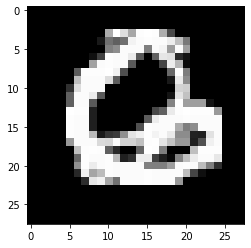

Label: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.] ⇒ [2 6]
Label: [ 78.48403662 -54.71331616 150.28095181  25.7871618  -40.27301211
  -7.3247983   92.51939669 -16.76108116  -7.64188839 -40.34348239] ⇒ [2 6]


In [44]:
rand0 = np.random.randint(0,len(x_train))
rand1 = np.random.randint(0,len(x_train))

x_train_overlap = np.maximum(x_train[rand0],x_train[rand1])
t_train_overlap = np.maximum(t_train[rand0],t_train[rand1])
plt.gray()
plt.imshow(x_train_overlap.reshape((28,28)))
plt.show()
y=model.forward(x_train_overlap)
print("Label:",t_train_overlap,"⇒",np.sort(t_train_overlap.argsort()[-2:]))
print("Label:",y,"⇒",np.sort(y.argsort()[-2:]))
